In [133]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

## Constants

In [153]:
EXAMPLE_FILE = './SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = './SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = './SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = './SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = './SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CATEGORY = 1
HAM_CATEGORY = 0

VOCAB_SIZE = 2500

DATA_JSON_FILE = './SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = './SpamData/01_Processing/word-id.csv'

TRAIN_DATA = './SpamData/02_Training/train-data.txt'
TEST_DATA = './SpamData/02_Training/test-data.txt'



WHALE_FILE = './SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = './SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP = './SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN = './SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

## Email body extraction in all mails

In [6]:
def email_body_generator(path):
    for root, dir, files in os.walk(path):
        
        for file in files:
            file_path = os.path.join(root, file)
            
            file = open(file_path, encoding='latin-1')
            is_body = False
            lines = list()
            for line in file:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            file.close()

            email_body = '\n'.join(lines)
            yield email_body , file

In [7]:
def df_from_directory(path, classification):
    rows = list()
    row_names = list()
    for email_body , file in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file)
    return pd.DataFrame(rows, index = row_names)

In [8]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CATEGORY)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
spam_emails.shape

(501, 2)

In [10]:
spam_emails2 = df_from_directory(SPAM_2_PATH, SPAM_CATEGORY)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
spam_emails2.shape

(1397, 2)

In [16]:
spams = [spam_emails, spam_emails2]

In [17]:
emails_spam = pd.concat(spams)

In [18]:
emails_spam.shape

(1898, 2)

In [19]:
emails_spam.head()

,MESSAGE,CATEGORY
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00249.5f45607c1bffe89f60ba1ec9f878039a' mode='r' encoding='latin-1'>,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00373.ebe8670ac56b04125c25100a36ab0510' mode='r' encoding='latin-1'>,ATTENTION: This is a MUST for ALL Computer Use...,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00214.1367039e50dc6b7adb0f2aa8aba83216' mode='r' encoding='latin-1'>,This is a multi-part message in MIME format.\n...,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00210.050ffd105bd4e006771ee63cabc59978' mode='r' encoding='latin-1'>,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00033.9babb58d9298daa2963d4f514193d7d6' mode='r' encoding='latin-1'>,This is the bottom line. If you can GIVE AWAY...,1


In [20]:
ham_emails1 = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CATEGORY)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
ham_emails1.shape

(2501, 2)

In [23]:
ham_emails2 = df_from_directory(EASY_NONSPAM_2_PATH, HAM_CATEGORY)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
ham_emails2.shape

(1400, 2)

In [25]:
hams = [ham_emails1, ham_emails2]

In [26]:
emails_ham = pd.concat(hams)

In [27]:
emails_ham.shape

(3901, 2)

In [28]:
data = pd.concat([emails_spam, emails_ham])

In [29]:
data.shape

(5799, 2)

### Reading JSON from file 

In [4]:
data = pd.read_json(DATA_JSON_FILE)

## Data cleaning : checking missing and null values 

In [32]:
data.MESSAGE.isnull().values.any() # checking for missing values 

False

In [35]:
(data.MESSAGE.str.len() == 0).any() # checking for null values (len of email body is 0)

True

In [49]:
(data.MESSAGE.str.len() == 0).sum()

0

In [37]:
data.MESSAGE.isnull().sum()

0

In [43]:
drops = data[data.MESSAGE.str.len() == 0].index

In [46]:
data[500:505]

,MESSAGE,CATEGORY
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00013.d3f0b591a65f116ea5d9d4ad919f83aa' mode='r' encoding='latin-1'>,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_2/01246.d0ee9c7ebf9d953b21de9414cc96c2f9' mode='r' encoding='latin-1'>,------=_NextPart_84815C5ABAF209EF376268C8\n\nC...,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_2/01099.f33c6cb5a233f19e1dc1956871c50681' mode='r' encoding='latin-1'>,<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT...,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_2/00346.d93a823fb3350a5da8f0c612ce1156cd' mode='r' encoding='latin-1'>,"Date:May 16,2002. \n\nEmail:edum@hkem.com. \n\...",1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_2/00012.cb9c9f2a25196f5b16512338625a85b4' mode='r' encoding='latin-1'>,\n\n<HTML>\n\n<BODY>\n\n\n\nOWN YOUR VERY OWN ...,1


In [47]:
data.drop(drops, inplace=True)

In [48]:
data.shape

(5796, 2)

## Add document ids as index to the dataframe 

In [50]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [51]:
data.head()

,MESSAGE,CATEGORY,DOC_ID
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00249.5f45607c1bffe89f60ba1ec9f878039a' mode='r' encoding='latin-1'>,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,0
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00373.ebe8670ac56b04125c25100a36ab0510' mode='r' encoding='latin-1'>,ATTENTION: This is a MUST for ALL Computer Use...,1,1
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00214.1367039e50dc6b7adb0f2aa8aba83216' mode='r' encoding='latin-1'>,This is a multi-part message in MIME format.\n...,1,2
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00210.050ffd105bd4e006771ee63cabc59978' mode='r' encoding='latin-1'>,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,3
<_io.TextIOWrapper name='./SpamData/01_Processing/spam_assassin_corpus/spam_1/00033.9babb58d9298daa2963d4f514193d7d6' mode='r' encoding='latin-1'>,This is the bottom line. If you can GIVE AWAY...,1,4


In [57]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,<_io.TextIOWrapper name='./SpamData/01_Process...
1,ATTENTION: This is a MUST for ALL Computer Use...,1,<_io.TextIOWrapper name='./SpamData/01_Process...
2,This is a multi-part message in MIME format.\n...,1,<_io.TextIOWrapper name='./SpamData/01_Process...
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,<_io.TextIOWrapper name='./SpamData/01_Process...
4,This is the bottom line. If you can GIVE AWAY...,1,<_io.TextIOWrapper name='./SpamData/01_Process...


In [59]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"I'm one of the 30,000 but it's not working ver...",0,<_io.TextIOWrapper name='./SpamData/01_Process...
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,<_io.TextIOWrapper name='./SpamData/01_Process...
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,<_io.TextIOWrapper name='./SpamData/01_Process...
5794,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,<_io.TextIOWrapper name='./SpamData/01_Process...
5795,"If you run Pick, and then use the ""New FTOC"" b...",0,<_io.TextIOWrapper name='./SpamData/01_Process...


## Saving the dataframe to disk as JSON 

In [3]:
data.to_json(DATA_JSON_FILE)

NameError: name 'data' is not defined

### Visualization of number of spam and ham emails 

In [63]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [64]:
spam_count = data.CATEGORY.value_counts()[1]
ham_count = data.CATEGORY.value_counts()[0]

In [65]:
category_names = ['Spam', 'Legit email']
category_size = [spam_count, ham_count]

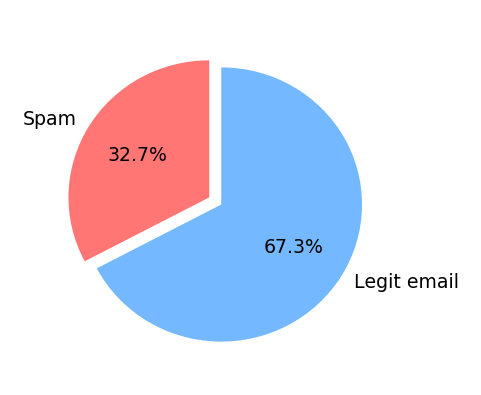

In [86]:
# Pie chart 
plt.figure(figsize=(2, 2), dpi=227)
custom_colors = ['#ff7675', '#74b9ff']
plt.pie(category_size, labels=category_names, textprops = {'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colors, explode=[0, 0.1])

plt.show()

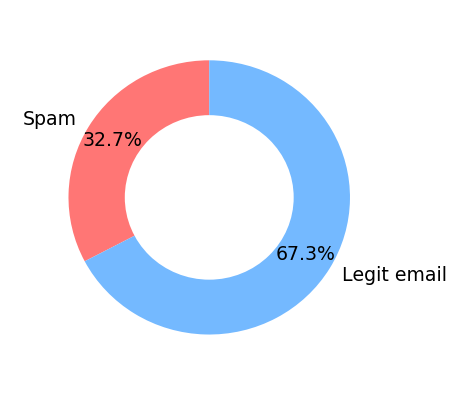

In [88]:
# Donut chart
plt.figure(figsize=(2, 2), dpi=227)
custom_colors = ['#ff7675', '#74b9ff']
plt.pie(category_size, labels=category_names, textprops = {'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colors, pctdistance=0.8)

centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

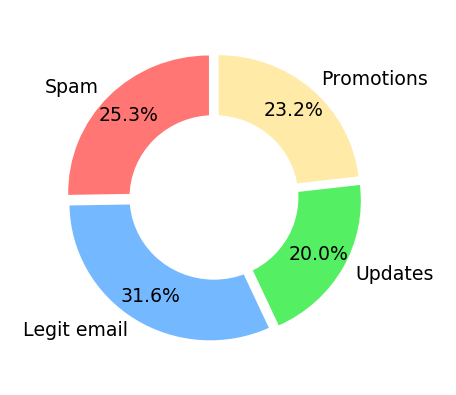

In [91]:
# Donut chart practice for 4 categories 
category_names = ['Spam', 'Legit email', 'Updates', 'Promotions']
category_size = [24, 30, 19, 22]
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
custom_colors = ['#ff7675', '#74b9ff', '#55ef64', '#ffeaa7']
plt.pie(category_size, labels=category_names, textprops = {'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Natural Language Processing

In [3]:
### Convert to lower case 

msg = 'ALl work and no play makes Shri a dull boy.'
msg.lower()

'all work and no play makes shri a dull boy.'

### Download the NLTK resources (Tokenizer and stopwords)

In [97]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ratzzz/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [99]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ratzzz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [111]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/ratzzz/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/ratzzz/nltk_data...
[nltk_data]   Unzipping corpora/shakespeare.zip.


True

### Converting to lower case and Tokenising

In [4]:
msg = 'ALl work and no play makes Shri a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'shri', 'a', 'dull', 'boy', '.']

### Removing stop words 

In [24]:
stop_words = set(stopwords.words('english'))

In [6]:
if 'hello' in stop_words: print('Fount it!') 

In [7]:
if 'hello' not in stop_words: print('Nope, Not in here.') 

Nope, Not in here.


In [8]:
msg = 'ALl work and no play makes Shri a dull boy.'
words = word_tokenize(msg.lower())

In [9]:
filtered_words = list()
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
    

In [10]:
filtered_words

['work', 'play', 'makes', 'shri', 'dull', 'boy', '.']

### Word stemming 

In [11]:
msg = 'ALl work and no play makes Shri a dull boy. You should always keep studying!'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = list()
for word in words:
    if word not in stop_words:
        stemmer_word = stemmer.stem(word)
        filtered_words.append(stemmer_word)
print(filtered_words)

['work', 'play', 'make', 'shri', 'dull', 'boy', '.', 'alway', 'keep', 'studi', '!']


### Remove punctuation 

In [12]:
'p'.isalpha()

True

In [14]:
'!'.isalpha()

False

In [7]:
msg = 'ALl work and no play makes Shri a dull boy. You should always keep studying!'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = list()
for word in words:
    if word not in stop_words and word.isalpha():
        stemmer_word = stemmer.stem(word)
        filtered_words.append(stemmer_word)
print(filtered_words)

['work', 'play', 'make', 'shri', 'dull', 'boy', 'alway', 'keep', 'studi']


### Remove HTML tags 

In [22]:
soup = BeautifulSoup(data.loc[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout
<http: optout="" www.insuranceiq.com

In [23]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

### Function for cleaning message 

In [5]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words = set(stopwords.words('english'))):
    # Convert to lower case and tokenise
    words = word_tokenize(message.lower())
    filtered_words = list()
    for word in words:
        # Remove stop words and punctuations 
        if word not in stop_words and word.isalpha():
            # convert to stem words
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [6]:
EXAMPLE_FILE = './SpamData/01_Processing/practice_email.txt'

In [7]:
with open(EXAMPLE_FILE, 'r', encoding='latin-1') as f:
    is_body = False
    lines = list()
    for line in f:
        if is_body:
            lines.append(line)
        elif line == '\n':
            is_body = True
email_body = '\n'.join(lines)
            

In [8]:
clean_words = clean_message(email_body)

In [9]:
print(clean_words)

['dear', 'mr', 'still', 'good', 'tide', 'staff', 'festiv', 'season', 'ahead', 'christma', 'crux', 'fulli', 'qualifi', 'santa', 'clau', 'wonder', 'whether', 'might', 'consid', 'run', 'santa', 'grotto', 'store', 'wait', 'probabl', 'think', 'make', 'special', 'well', 'first', 'made', 'sever', 'chang', 'characteris', 'father', 'christma', 'rather', 'greet', 'children', 'shout', 'ho', 'ho', 'ho', 'prefer', 'whisper', 'phrase', 'depend', 'unfathom', 'cruel', 'world', 'live', 'addit', 'gift', 'rang', 'felt', 'hoop', 'holder', 'note', 'also', 'enclos', 'sketch', 'radic', 'redesign', 'santa', 'outfit', 'renam', 'charact', 'lord', 'buckl', 'would', 'interest', 'employ', 'promis', 'never', 'let', 'look', 'forward', 'hear', 'best', 'wish', 'robin', 'cooper', 'excerpt', 'book', 'timewast', 'letter', 'robin', 'cooper']


In [10]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words = set(stopwords.words('english'))):
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    msg_no_html = soup.get_text()
    
    # Convert to lower case and tokenise
    words = word_tokenize(msg_no_html.lower())
    filtered_words = list()
    for word in words:
        # Remove stop words and punctuations 
        if word not in stop_words and word.isalpha():
            # convert to stem words
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [11]:
res = clean_msg_no_html(data.at[2, 'MESSAGE'])

In [12]:
print(res)

['messag', 'mime', 'format', 'dare', 'tri', 'find', 'better', 'annuiti', 'guarante', 'year', 'surrend', 'agent', 'commiss', 'age', 'call', 'today', 'inform', 'ext', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'pmg', 'financi', 'servic', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'commun', 'sent', 'insur', 'profession', 'remov', 'mail', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic', 'dare', 'find', 'better', 'annuiti', 'call', 'today', 'inform', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'sent', 'insur', 'profession', 'remov', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic']


# Apply cleaning on all email bodies 

### slicing dataframes

In [13]:
data.at[2, 'MESSAGE']

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [47]:
data.iat[2, 1]

1

In [50]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
5,------=_NextPart_000_00B8_51E06B6A.C8586B31\n\...,1,"{'buffer': {'closed': True, 'mode': 'rb', 'raw..."
6,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",1,"{'buffer': {'closed': True, 'mode': 'rb', 'raw..."
7,<HR>\n\n<html>\n\n<head>\n\n <title>Secured I...,1,"{'buffer': {'closed': True, 'mode': 'rb', 'raw..."
8,"<table width=""600"" border=""20"" align=""center"" ...",1,"{'buffer': {'closed': True, 'mode': 'rb', 'raw..."
9,"<html>\n\n\n\n<head>\n\n<meta http-equiv=""Cont...",1,"{'buffer': {'closed': True, 'mode': 'rb', 'raw..."
10,"Dear Consumers, Increase your Business Sales! ...",1,"{'buffer': {'closed': True, 'mode': 'rb', 'raw..."


In [64]:
data.MESSAGE.iloc[0:3]

0    Dear Homeowner,\n\n \n\nInterest Rates are at ...
1    ATTENTION: This is a MUST for ALL Computer Use...
2    This is a multi-part message in MIME format.\n...
Name: MESSAGE, dtype: object

In [14]:
nested_list = first_emails.apply(clean_message)

NameError: name 'first_emails' is not defined

In [66]:
flat_list = [item for sublist in nested_list for item in sublist]

In [67]:
len(flat_list)

222

In [60]:
flat_list = list()

for sublist in nested_list:
    for item in sublist:
        flat_list.append(item)
        
print(len(flat_list))

222


In [15]:
%%time 

nested_list = data.MESSAGE.apply(clean_msg_no_html)

/Users/ratzzz/anaconda3/envs/rat/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 44.4 s, sys: 252 ms, total: 44.6 s
Wall time: 45 s


In [16]:
nested_list.tail()

5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

### Slicing dataframes based on a logic 

In [74]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [17]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [18]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [19]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [20]:
nested_list_spam.shape

(1896,)

In [21]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

In [22]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

In [96]:
print('Total number of words in cleaned dataset of Spam email bodies are: ', spam_words.shape)
print('Total number of words in cleaned dataset of normal email bodies are: ', normal_words.shape)

Total number of words in cleaned dataset of Spam email bodies are:  (13284,)
Total number of words in cleaned dataset of normal email bodies are:  (20755,)


In [100]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [101]:
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Creating a word cloud 

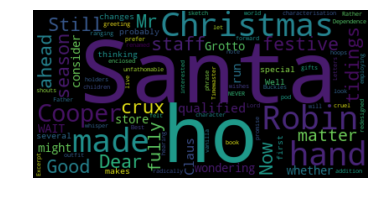

In [23]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [25]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [28]:
word_list = [''.join(word) for word in example_corpus]

In [29]:
novel_str = ' '.join(word_list)

(-0.5, 399.5, 199.5, -0.5)

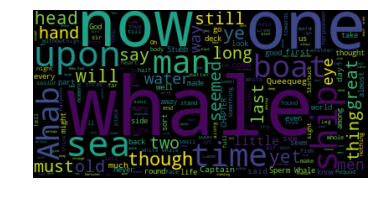

In [30]:
word_cloud = WordCloud().generate(novel_str)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

In [31]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

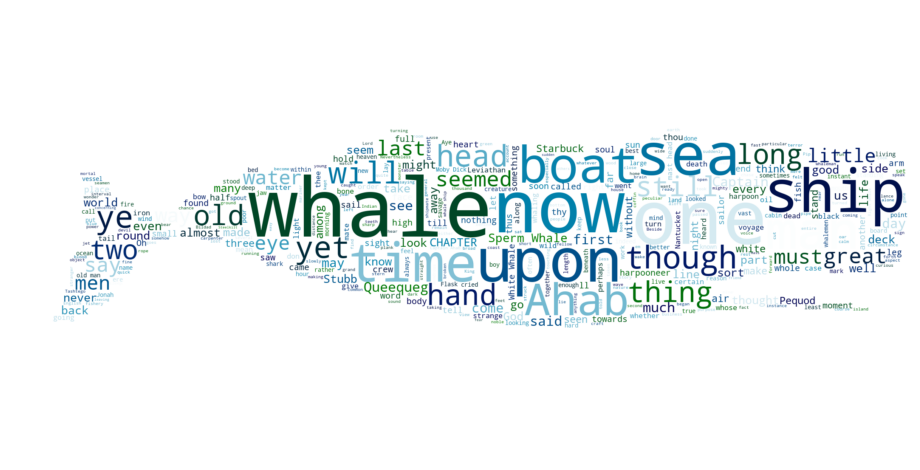

In [32]:
word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean')
word_cloud.generate(novel_str)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
example_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in example_corpus]
novel_str = ' '.join(word_list)

In [40]:
skull_icon = Image.open(SKULL_FILE)

image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)

skull_mask = np.array(image_mask)

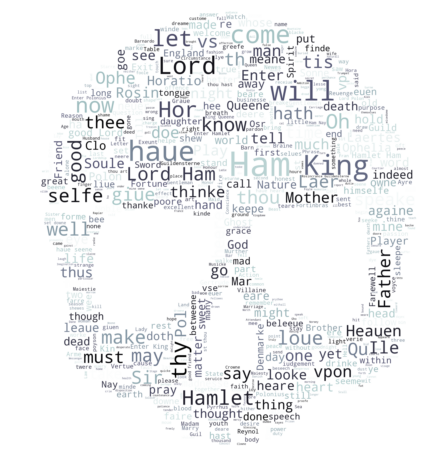

In [44]:
word_cloud = WordCloud(mask=skull_mask, background_color='white', max_words=600, colormap='bone')
word_cloud.generate(novel_str)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word cloud of Spam and Normal words

In [53]:
# For normal words
normal_icon = Image.open(THUMBS_UP)
mask = Image.new(mode='RGB', size=normal_icon.size, color=(255, 255, 255))
mask.paste(normal_icon, box=normal_icon)

im_arr = np.array(mask)

In [54]:
normal_str = ' '.join(flat_list_ham)

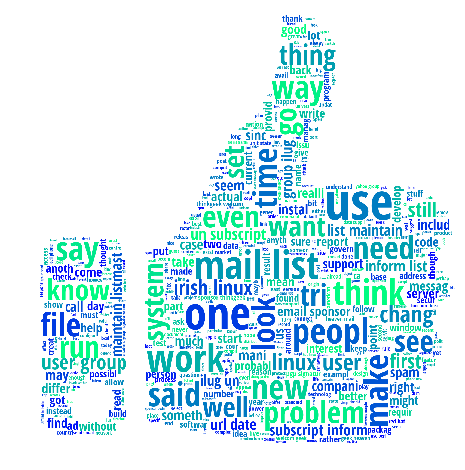

In [55]:
word_cloud = WordCloud(font_path='./SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf', 
                       mask=im_arr, 
                       background_color='white', 
                       max_words=500, 
                       colormap='winter')
word_cloud.generate(normal_str)
plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud)

In [56]:
# For spam words 
spam_icon = Image.open(THUMBS_DOWN)
mask = Image.new(mode='RGB', size=spam_icon.size, color=(255, 255, 255))
mask.paste(spam_icon, box=spam_icon)

im_arr = np.array(mask)

In [57]:
spam_str = ' '.join(flat_list_spam)

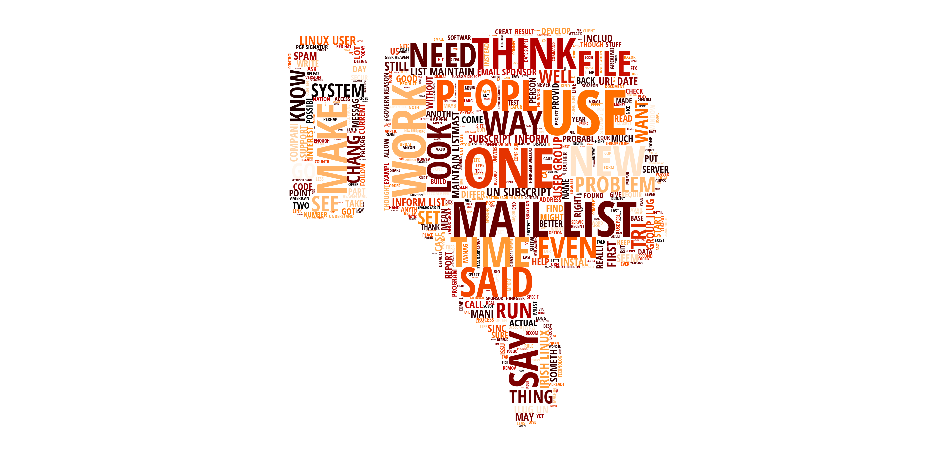

In [61]:
word_cloud = WordCloud(font_path='./SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf', 
                       mask=im_arr, 
                       background_color='white', 
                       max_words=500, 
                       colormap='gist_heat')
word_cloud.generate(normal_str.upper())
plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud)

## Generate Vocabulary and Dictionary

In [63]:
stemmed_word_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_word_list for item in sublist]

In [64]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
unique_words.head()


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [70]:
frequent_words = unique_words[:VOCAB_SIZE]

In [71]:
frequent_words.head(10)

http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64

## Create a Vocab dataframe

In [85]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save vocab dataframe to disk

In [88]:
vocab.to_csv(WORD_ID_FILE,index=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Excerise 


In [100]:
word = 'scienc'

if word in frequent_words:
    print('True')
else:
    print('False')

True


In [95]:
# any(vocab.VOCAB_WORD == 'machine')

False

## find the email with most number of words

In [104]:
stemmed_word_list = data.MESSAGE.apply(clean_msg_no_html)


/Users/ratzzz/anaconda3/envs/rat/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [112]:
frequency_email = [len(sublist) for sublist in stemmed_word_list]

In [126]:
np.argmax(frequency_email)

5401

In [124]:
print(stemmed_word_list[5401])

['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'synchron', 'run', 'osx', 'switch', 'treatment', 'filenam', 'consid', 'file', 'osx', 'yet', 'fulli', 'work',

In [125]:
data.at[5401, 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features and sparse matrix

## Generate dataframe with one word as one column

In [128]:
type(stemmed_word_list)

pandas.core.series.Series

In [129]:
type(stemmed_word_list.tolist())

list

In [130]:
word_columns_df = pd.DataFrame.from_records(stemmed_word_list.tolist())

In [131]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [132]:
word_columns_df.shape

(5796, 7671)

## Split train and test data

In [134]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, 
                                                    test_size=0.3, random_state=42)

In [135]:
X_train.shape

(4057, 7671)

In [136]:
X_test.shape

(1739, 7671)

In [139]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [140]:
y_train.head()

4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a sparse matrix

In [141]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [144]:
def create_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    
    df: A dataframe with words in columns and indexed by document id (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: categtory of the document (y_train or y_test)

    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    
    dict_list = list()
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            
            if word in word_set:
                
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 
                       'OCCURENCE': 1, 'WORD_ID': word_id,}
                dict_list.append(item)
    
    
    return pd.DataFrame(dict_list)

In [145]:
%%time

sparse_train_df = create_sparse_matrix(X_train, word_index, y_train)

CPU times: user 3min 43s, sys: 2.39 s, total: 3min 45s
Wall time: 3min 57s


In [147]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
445893,1,860,1,126
445894,1,860,1,649
445895,1,860,1,518
445896,1,860,1,1388
445897,1,860,1,1081


In [148]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [150]:
train_grouped = train_grouped.reset_index()

In [152]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
265470,5795,1893,0,1
265471,5795,1918,0,2
265472,5795,2148,0,1
265473,5795,2295,0,1
265474,5795,2472,0,1


### Saving as .txt files

In [155]:
np.savetxt(TRAIN_DATA, train_grouped, fmt='%d')

In [156]:
sparse_test_df = create_sparse_matrix(X_test, word_index, y_test)

In [159]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped = test_grouped.reset_index()

In [160]:
np.savetxt(TEST_DATA, test_grouped, fmt='%d')

In [161]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,19,1,2
4,8,26,1,1


In [162]:
test_ids = set(test_grouped.DOC_ID)

In [163]:
len(test_ids)

1724

In [164]:
len(X_test)

1739

In [165]:
set(X_test.index.values) - test_ids

{14, 325, 416, 445, 452, 479, 576, 594, 681, 856, 859, 1001, 1042, 1109, 1407}

In [171]:
data.MESSAGE[1096]

'<HTML><FONT  COLOR=3D"#ff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COLOR: =\n\n#ffffff" SIZE=3D3 PTSIZE=3D12> &nbsp;<B><!--#rotate>Terific!!   Instantly =\n\n</FONT><FONT  COLOR=3D"#ff0000" BACK=3D"#ff80ff" style=3D"BACKGROUND-COLOR=\n\n: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D=\n\n"0">S e x u a l l y Attract</FONT></FONT><FONT  COLOR=3D"#ff00ff" BACK=3D"=\n\n#ffffff" style=3D"BACKGROUND-COLOR: #ffffff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D=\n\n"SANSSERIF" FACE=3D"Arial" LANG=3D"0"> with nature\'s secret weapon... Pher=\n\nomones!! &nbsp;&nbsp;*****<BR>\n\n<BR>\n\nInvisible and undetectable, when unknowingly inhaled, Pheromone Concentrat=\n\ne  unblocks all restraints and releases the raw  animal s e x drive!<BR>\n\n<BR>\n\nThis is the strongest concentration of </FONT><FONT  COLOR=3D"#ff0000" BAC=\n\nK=3D"#ff80ff" style=3D"BACKGROUND-COLOR: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAM=\n\nILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D"0">HUMAN Pheromones</FONT></FONT>=\n\n